In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import gdown

url = 'https://drive.google.com/u/0/uc?id=1pG0GgEJ5--YHHPrsoFaGk8nR0_gLC13M'
output = 'recommender_system.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1pG0GgEJ5--YHHPrsoFaGk8nR0_gLC13M
To: /content/recommender_system.zip
100%|██████████| 239M/239M [00:04<00:00, 55.8MB/s]


'recommender_system.zip'

In [ ]:
!unzip "/content/recommender_system.zip"

Archive:  /content/recommender_system.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [ ]:
metadata = pd.read_csv('/content/movies_metadata.csv')

# Print the first three rows
metadata.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [ ]:
len(metadata)

45466

In [ ]:
# data columns
print(metadata.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [ ]:
# calculate C
C = metadata['vote_average'].mean()
print(C)

5.618207215134185


In [ ]:
# Calculate M
M = metadata['vote_count'].quantile(0.90)
print(M)
print(metadata.shape)

160.0
(45466, 24)


In [ ]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= M]
q_movies.shape

(4555, 24)

In [ ]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, M=M, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+M) * R) + (M/(M+v) * C)

In [ ]:
print(q_movies.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [ ]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


In [ ]:
#Print plot overviews of the first 5 movies.
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# #Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
# tfidf = TfidfVectorizer(stop_words='english',max_features=100)

# #Replace NaN with an empty string
# metadata['overview'] = metadata['overview'].fillna('')

# #Construct the required TF-IDF matrix by fitting and transforming the data
# tfidf_matrix = tfidf.fit_transform(metadata['overview'])

# #Output the shape of tfidf_matrix
# tfidf_matrix.shape

In [ ]:
# tfidf_matrix.toarray()

In [ ]:
# Limit the data for memory size
temporary_metadata = metadata[:10000]

In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
temporary_metadata['overview'] = temporary_metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(temporary_metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(10000, 32350)

In [ ]:
# tfidf_matrix.toarray()

In [ ]:
# Compute the cosine Similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

(10000, 10000)

In [ ]:
cosine_sim[500]

array([0.        , 0.00714213, 0.        , ..., 0.02236148, 0.        ,
       0.        ])

In [ ]:
list(enumerate(cosine_sim[500]))

[(0, 0.0),
 (1, 0.00714212619992065),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.008260348474131199),
 (11, 0.0),
 (12, 0.0),
 (13, 0.008945818560110914),
 (14, 0.0),
 (15, 0.0),
 (16, 0.038354283677513826),
 (17, 0.0),
 (18, 0.015401078782334099),
 (19, 0.00904749092800644),
 (20, 0.014272674510182978),
 (21, 0.0),
 (22, 0.02062447130296236),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 0.0),
 (27, 0.0),
 (28, 0.0),
 (29, 0.0),
 (30, 0.0),
 (31, 0.007543951502253908),
 (32, 0.0),
 (33, 0.006104345148568145),
 (34, 0.00486416261910659),
 (35, 0.0),
 (36, 0.040768575136050644),
 (37, 0.010526277633651845),
 (38, 0.004813261144082918),
 (39, 0.0),
 (40, 0.0),
 (41, 0.008525674049602146),
 (42, 0.015912841962631964),
 (43, 0.0),
 (44, 0.0),
 (45, 0.0),
 (46, 0.0),
 (47, 0.01569468277312055),
 (48, 0.0),
 (49, 0.0),
 (50, 0.02139744476786558),
 (51, 0.0),
 (52, 0.011351984854657512),
 (53, 0.0),
 (54, 0.0),
 (55, 0.0),
 (56, 0.0),
 (57, 0.0

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [ ]:
indices

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Subdue                         45461
Century of Birthing            45462
Betrayal                       45463
Satan Triumphant               45464
Queerama                       45465
Length: 45466, dtype: int64

In [ ]:
indices['The Dark Knight Rises']

18252

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    try:
      # Get the pairwsie similarity scores of all movies with that movie
      sim_scores = list(enumerate(cosine_sim[idx]))

      # Sort the movies based on the similarity scores
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

      # Get the scores of the 10 most similar movies
      sim_scores = sim_scores[1:11]

      # Get the movie indices
      movie_indices = [i[0] for i in sim_scores]

      return metadata['title'].iloc[movie_indices]
      # Return the top 10 most similar movies
    except:  
      print('no such index')

In [ ]:
print(get_recommendations('The Dark Knight Rises'))

no such index
None


In [ ]:
get_recommendations('The Godfather')

1178     The Godfather: Part II
1914    The Godfather: Part III
8653               Violent City
6711                   Mobsters
6977            Queen of Hearts
8191                     Eulogy
2891             American Movie
4324                       Made
4464            Family Business
5689        The Young Americans
Name: title, dtype: object

In [ ]:
# Load keywords and credits
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')

In [ ]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
credits.shape

(45476, 3)

In [ ]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
keywords.shape

(46419, 2)

In [ ]:
# Remove rows with bad IDs.
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [ ]:
# Print the first two movies of your newly merged metadata
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [ ]:
metadata.shape

(46628, 27)

In [ ]:
len(metadata)

46628

In [ ]:
# Limit the data for memory size
metadata = metadata[:10000]

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [ ]:
metadata['crew']

0       [{'credit_id': '52fe4284c3a36847f8024f49', 'de...
1       [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...
2       [{'credit_id': '52fe466a9251416c75077a89', 'de...
3       [{'credit_id': '52fe44779251416c91011acb', 'de...
4       [{'credit_id': '52fe44959251416c75039ed7', 'de...
                              ...                        
9995    [{'credit_id': '52fe467cc3a36847f81019f9', 'de...
9996    [{'credit_id': '59665828c3a36825e8116b9a', 'de...
9997    [{'credit_id': '52fe481ac3a368484e0e94f9', 'de...
9998    [{'credit_id': '52fe46349251416c9104cb19', 'de...
9999    [{'credit_id': '52fe4518c3a368484e04830d', 'de...
Name: crew, Length: 10000, dtype: object

In [ ]:
metadata['crew'][0]

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f55',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Screenplay',
  'name': 'Andrew Stanton',
  'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f5b',
  'department': 'Writing',
  'gender': 2,
  'id': 12892,
  'job': 'Screenplay',
  'name': 'Joel Cohen',
  'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f61',
  'department': 'Writing',
  'gender': 0,
  'id': 12893,
  'job': 'Screenplay',
  'name': 'Alec Sokolow',
  'profile_path': '/v79vlRYi94BZUQnkkyzn

In [ ]:
metadata['cast']

0       [{'cast_id': 14, 'character': 'Woody (voice)',...
1       [{'cast_id': 1, 'character': 'Alan Parrish', '...
2       [{'cast_id': 2, 'character': 'Max Goldman', 'c...
3       [{'cast_id': 1, 'character': 'Savannah 'Vannah...
4       [{'cast_id': 1, 'character': 'George Banks', '...
                              ...                        
9995    [{'cast_id': 4, 'character': 'Calvin Menhoffer...
9996    [{'cast_id': 1, 'character': 'Frank Kavanaugh'...
9997    [{'cast_id': 1029, 'character': 'Thomas Hudson...
9998    [{'cast_id': 1, 'character': 'Lt. Michael Gray...
9999    [{'cast_id': 1, 'character': 'The Judge', 'cre...
Name: cast, Length: 10000, dtype: object

In [ ]:
metadata['cast'][0]

[{'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'},
 {'cast_id': 15,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe4284c3a36847f8024f99',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1,
  'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
 {'cast_id': 16,
  'character': 'Mr. Potato Head (voice)',
  'credit_id': '52fe4284c3a36847f8024f9d',
  'gender': 2,
  'id': 7167,
  'name': 'Don Rickles',
  'order': 2,
  'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 {'cast_id': 17,
  'character': 'Slinky Dog (voice)',
  'credit_id': '52fe4284c3a36847f8024fa1',
  'gender': 2,
  'id': 12899,
  'name': 'Jim Varney',
  'order': 3,
  'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
 {'cast_id': 18,
  'character': 'Rex (voice)',
  'credit_id': '52fe4284c3a36847f8024fa5',
  'gender': 2,
  'id': 12900,
 

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [ ]:
# Print the new features of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(10)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,"[baby, midlife crisis, confidence]",[Comedy]
5,Heat,"[Al Pacino, Robert De Niro, Val Kilmer]",Michael Mann,"[robbery, detective, bank]","[Action, Crime, Drama]"
6,Sabrina,"[Harrison Ford, Julia Ormond, Greg Kinnear]",Sydney Pollack,"[paris, brother brother relationship, chauffeur]","[Comedy, Romance]"
7,Tom and Huck,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",Peter Hewitt,[],"[Action, Adventure, Drama]"
8,Sudden Death,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,"[terrorist, hostage, explosive]","[Action, Adventure, Thriller]"
9,GoldenEye,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]",Martin Campbell,"[cuba, falsely accused, secret identity]","[Adventure, Action, Thriller]"


In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

In [ ]:
metadata['soup'].head(5)

0    jealousy toy boy tomhanks timallen donrickles ...
1    boardgame disappearance basedonchildren'sbook ...
2    fishing bestfriend duringcreditsstinger walter...
3    basedonnovel interracialrelationship singlemot...
4    baby midlifecrisis confidence stevemartin dian...
Name: soup, dtype: object

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather', cosine_sim2)

1934           The Godfather: Part III
1199            The Godfather: Part II
8001    The Night of the Following Day
7772                          Mitchell
1186                    Apocalypse Now
1648                  Ill Gotten Gains
3487        Jails, Hospitals & Hip-Hop
4012                  Gardens of Stone
5309                       The Gambler
5                                 Heat
Name: title, dtype: object

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [ ]:
train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [ ]:
# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None


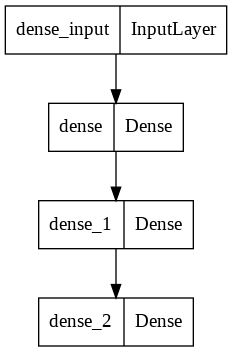

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())
plot_model(model)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
44/44 [==============================] - 4s 21ms/step - loss: 0.4720 - binary_accuracy: 0.8138 - val_loss: 0.3559 - val_binary_accuracy: 0.8684
Epoch 2/20
44/44 [==============================] - 1s 15ms/step - loss: 0.2714 - binary_accuracy: 0.9077 - val_loss: 0.2905 - val_binary_accuracy: 0.8800
Epoch 3/20
44/44 [==============================] - 1s 15ms/step - loss: 0.2084 - binary_accuracy: 0.9265 - val_loss: 0.2671 - val_binary_accuracy: 0.8900
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.1701 - binary_accuracy: 0.9408 - val_loss: 0.2758 - val_binary_accuracy: 0.8824
Epoch 5/20
44/44 [==============================] - 1s 15ms/step - loss: 0.1468 - binary_accuracy: 0.9502 - val_loss: 0.2857 - val_binary_accuracy: 0.8824
Epoch 6/20
44/44 [==============================] - 1s 15ms/step - loss: 0.1266 - binary_accuracy: 0.9572 - val_loss: 0.3025 - val_binary_accuracy: 0.8816
Epoch 7/20
44/44 [==============================] - 1s 15ms/step - los

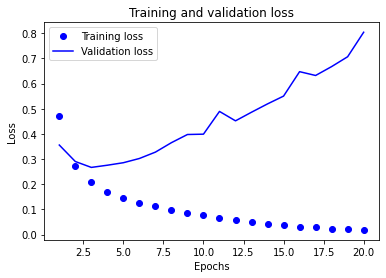

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

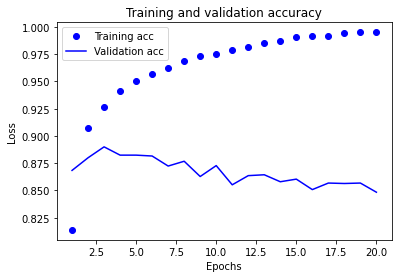

In [ ]:
plt.clf()   # clear figure
acc_values = history.history['binary_accuracy']
val_acc_values = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
DATA_PATH=Path('.')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.4M      0  0:00:03  0:00:03 --:--:-- 21.4M


In [ ]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
for t in trn_texts[:10]:
  print(t)

!!!!! OF COURSE THERE'S SPOILERS !!!!! I'm sure this project started off as a screen writing workshop on avoiding clichés in horror movies: Female protagonist - Check Bad things happen to drug takers - Check Heorine knocks out villain - Check Heroine doesn't notice villain recovering unconsciousness - Check Frame the sequence so we see recovered villain creep up behind heroine - Check Unfortunately it seems someone has sent this cliché list to a film studio instead of using it for class . Dear oh dear if only London transport was as regular as the clichés turning up here . In fact there's so many clichés and seen it all before moments that no one actually thought about going into detail as to what the eponymous creep is or how long he's been killing people on the underground . I'm led to believe it's the result of some human experiment and perhaps it's not until that night he decided to take his revenge out on humanity but all this is so vague as to be meaningless Not to be totally neg

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
import unicodedata
import re
re1 = re.compile(r'  +')
import html

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='binary')
x_test = tok.texts_to_matrix(tst_texts, mode='binary')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Epoch 1/20
30/30 [==============================] - 2s 42ms/step - loss: 0.5469 - binary_accuracy: 0.7860 - val_loss: 0.4310 - val_binary_accuracy: 0.8705
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3515 - binary_accuracy: 0.8956 - val_loss: 0.3345 - val_binary_accuracy: 0.8821
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2571 - binary_accuracy: 0.9185 - val_loss: 0.3103 - val_binary_accuracy: 0.8819
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2014 - binary_accuracy: 0.9355 - val_loss: 0.2970 - val_binary_accuracy: 0.8832
Epoch 5/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1630 - binary_accuracy: 0.9467 - val_loss: 0.2913 - val_binary_accuracy: 0.8835
Epoch 6/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1356 - binary_accuracy: 0.9569 - val_loss: 0.3075 - val_binary_accuracy: 0.8809
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - los

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

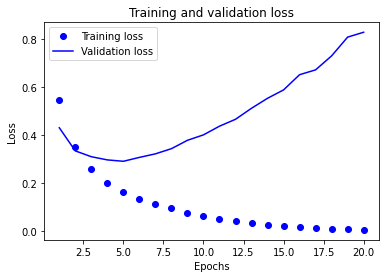

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

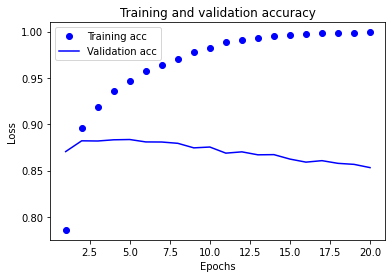

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='count')
x_test = tok.texts_to_matrix(tst_texts, mode='count')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 0.5504 - binary_accuracy: 0.7881 - val_loss: 0.4261 - val_binary_accuracy: 0.8658
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.3476 - binary_accuracy: 0.8949 - val_loss: 0.3398 - val_binary_accuracy: 0.8811
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2587 - binary_accuracy: 0.9159 - val_loss: 0.3079 - val_binary_accuracy: 0.8845
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2064 - binary_accuracy: 0.9327 - val_loss: 0.2940 - val_binary_accuracy: 0.8875
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1697 - binary_accuracy: 0.9439 - val_loss: 0.2990 - val_binary_accuracy: 0.8871
Epoch 6/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1436 - binary_accuracy: 0.9538 - val_loss: 0.3251 - val_binary_accuracy: 0.8805
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - los

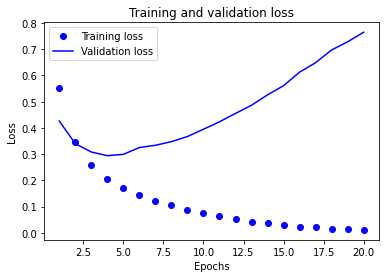

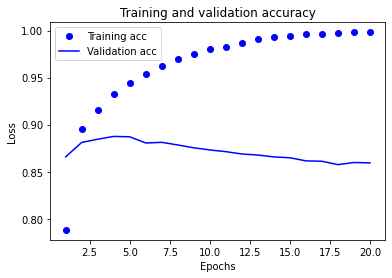

In [ ]:




x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='freq')
x_test = tok.texts_to_matrix(tst_texts, mode='freq')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 0.6889 - binary_accuracy: 0.7195 - val_loss: 0.6832 - val_binary_accuracy: 0.7664
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.6757 - binary_accuracy: 0.8246 - val_loss: 0.6681 - val_binary_accuracy: 0.8269
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6578 - binary_accuracy: 0.8329 - val_loss: 0.6492 - val_binary_accuracy: 0.8272
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6352 - binary_accuracy: 0.8441 - val_loss: 0.6260 - val_binary_accuracy: 0.8255
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6088 - binary_accuracy: 0.8520 - val_loss: 0.5992 - val_binary_accuracy: 0.8396
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5788 - binary_accuracy: 0.8567 - val_loss: 0.5702 - val_binary_accuracy: 0.8422
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - los

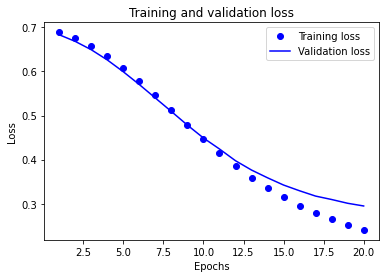

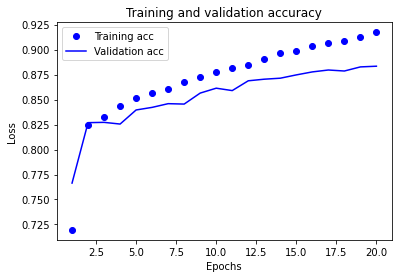

In [ ]:




x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(trn_texts + tst_texts)
#vocab_sz = len(tok.word_index)

# Extract binary BoW features
x_train = tok.texts_to_matrix(trn_texts, mode='tfidf')
x_test = tok.texts_to_matrix(tst_texts, mode='tfidf')
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

Epoch 1/20
30/30 [==============================] - 2s 37ms/step - loss: 0.4527 - binary_accuracy: 0.7964 - val_loss: 0.3268 - val_binary_accuracy: 0.8735
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2144 - binary_accuracy: 0.9239 - val_loss: 0.3476 - val_binary_accuracy: 0.8681
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1339 - binary_accuracy: 0.9569 - val_loss: 0.3466 - val_binary_accuracy: 0.8700
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0903 - binary_accuracy: 0.9719 - val_loss: 0.3704 - val_binary_accuracy: 0.8736
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0595 - binary_accuracy: 0.9826 - val_loss: 0.4274 - val_binary_accuracy: 0.8700
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0377 - binary_accuracy: 0.9913 - val_loss: 0.4774 - val_binary_accuracy: 0.8676
Epoch 7/20
30/30 [==============================] - 1s 28ms/step - los

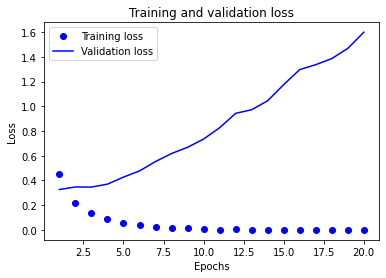

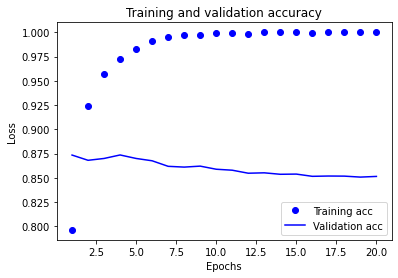

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

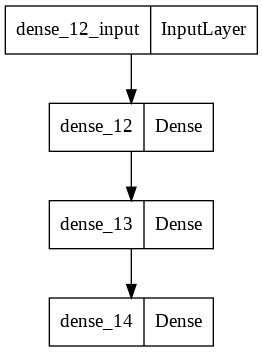

In [ ]:
plot_model(model)

In [ ]:
inp_1 = layers.Input(shape=100)
inp_2 = layers.Input(shape=100)

# Branch 1
x = layers.Dense(50)(inp_1)
x = layers.Dense(50)(x)
out_1 = layers.Dense(25)(x)

# Branch 2
x = layers.Dense(50)(inp_2)
x = layers.Dense(50)(x)
out_2 = layers.Dense(25)(x)

merged = layers.concatenate([out_1, out_2])

out_1 = layers.Dense(100)(merged)
out_2 = layers.Dense(100)(merged)

# func
model = models.Model(inputs=[inp_1, inp_2], outputs=[out_1, out_2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 50)           5050        ['input_1[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 50)           5050        ['input_2[0][0]']                
                                                                                              

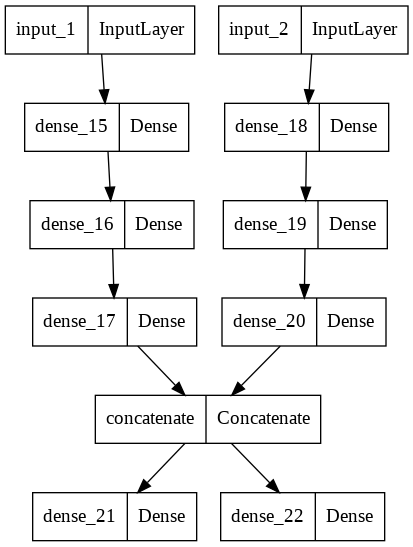

In [ ]:
plot_model(model)

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_23 (Dense)            (None, 16)                160016    
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None


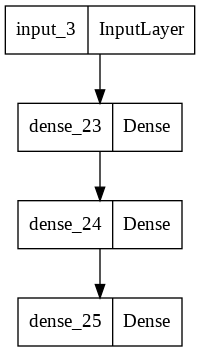

In [ ]:

inp = layers.Input(shape=(10000,))
x = layers.Dense(16, activation='relu')(inp)
x = layers.Dense(16, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inp, out)
print(model.summary())
plot_model(model)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
44/44 [==============================] - 3s 36ms/step - loss: 0.4746 - binary_accuracy: 0.8177 - val_loss: 0.3578 - val_binary_accuracy: 0.8728
Epoch 2/20
44/44 [==============================] - 1s 18ms/step - loss: 0.2771 - binary_accuracy: 0.9073 - val_loss: 0.2876 - val_binary_accuracy: 0.8884
Epoch 3/20
44/44 [==============================] - 1s 14ms/step - loss: 0.2099 - binary_accuracy: 0.9294 - val_loss: 0.2712 - val_binary_accuracy: 0.8832
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.1732 - binary_accuracy: 0.9415 - val_loss: 0.2765 - val_binary_accuracy: 0.8816
Epoch 5/20
44/44 [==============================] - 1s 15ms/step - loss: 0.1468 - binary_accuracy: 0.9510 - val_loss: 0.2885 - val_binary_accuracy: 0.8856
Epoch 6/20
44/44 [==============================] - 1s 14ms/step - loss: 0.1285 - binary_accuracy: 0.9574 - val_loss: 0.3039 - val_binary_accuracy: 0.8780
Epoch 7/20
44/44 [==============================] - 1s 15ms/step - los

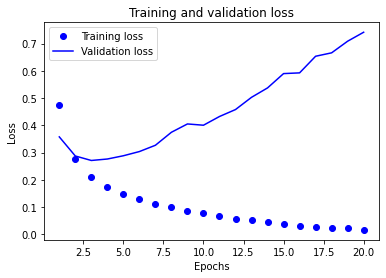

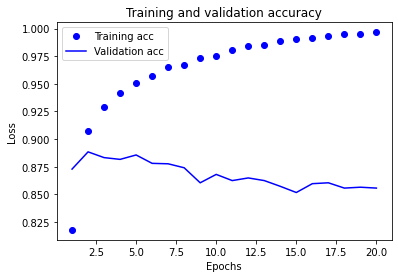

In [ ]:

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))



acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



plt.clf()   # clear figure
acc_values = history.history['binary_accuracy']
val_acc_values = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# define documents
docs = ['Well done!',
'Good work','Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']
# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]
# integer encode the documents
#vocab_size = 50
labels = np.array(labels)
#encoded_docs = [one_hot(d, vocab_size) for d in docs]
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 8)              120       
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None


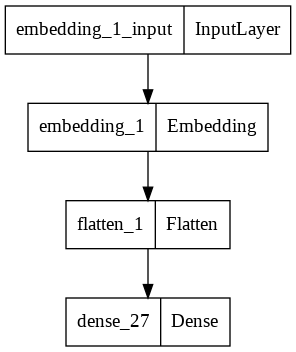

In [ ]:
# define the model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 8, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())
plot_model(model)

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# fit the model
model.fit(np.array(padded_docs), np.array(labels), epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 89.999998


In [ ]:
vocab_size = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)



max_length = 100
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post')

In [ ]:

# define the model
emb_sz = 50
model = models.Sequential()
model.add(layers.Embedding(vocab_size+1, emb_sz, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(25))
model.add(layers.Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(np.array(x_train), np.array(y_train), validation_data=(np.array(x_val), np.array(y_val)), epochs=10, verbose=1)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500050    
                                                                 
 flatten_2 (Flatten)         (None, 5000)              0         
                                                                 
 dense_28 (Dense)            (None, 25)                125025    
                                                                 
 dense_29 (Dense)            (None, 1)                 26        
                                                                 
Total params: 625,101
Trainable params: 625,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
704/704 [==============================] - 4s 5ms/step - loss: 0.4253 - acc: 0.7941 - val_loss: 0.3493 - val_acc: 0.8428
Epoch 2/10
704/704 [============================

In [ ]:
X = np.array([[2, 3], [3, 5], [5, 8]])
Y = np.array([[1, 0], [2, 1]])

In [ ]:
X

array([[2, 3],
       [3, 5],
       [5, 8]])

In [ ]:
Y 

array([[1, 0],
       [2, 1]])

In [ ]:
pairwise_kernels(X, Y, metric='linear')

array([[ 2.,  7.],
       [ 3., 11.],
       [ 5., 18.]])

In [ ]:
X = np.array([[2, 3], [3, 5], [5, 8]])
Y = np.array([[1, 0], [2, 1]])

In [ ]:
cosine_similarity(X, Y)

array([[0.5547002 , 0.86824314],
       [0.51449576, 0.84366149],
       [0.52999894, 0.85328183]])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
Total params: 0
Trainable params: 0
Non-trainable params: 0
________________________________

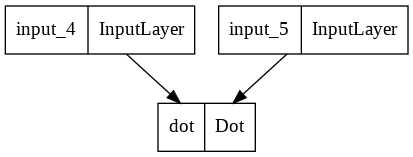

In [ ]:
inp_1 = layers.Input(shape=(10000,))
inp_2 = layers.Input(shape=(10000,))
out = layers.Dot(axes=1)([inp_1, inp_2])
model = models.Model(inputs=[inp_1, inp_2], outputs=out)
model.summary()
plot_model(model)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       100000      ['input_6[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 100)       200000      ['input_7[0][0]']                
                                                                                            

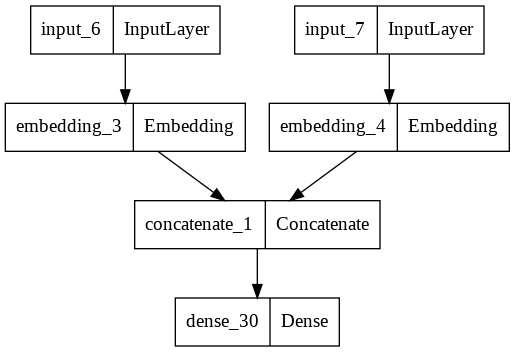

In [ ]:
# Number of latent factors
emb_sz = 100

# User embeddings
inp_1 = layers.Input(shape=(1,))
emb_1 = layers.Embedding(1000, emb_sz)(inp_1)

# Movie embeddings
inp_2 = layers.Input(shape=(1,))
emb_2 = layers.Embedding(2000, emb_sz)(inp_2)

emb = layers.concatenate([emb_1, emb_2])
out = layers.Dense(100)(emb)

model = models.Model(inputs=[inp_1, inp_2], outputs=out)
print(model.summary())
plot_model(model)

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2022-11-21 22:34:59--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.63MB/s    in 0.2s    

2022-11-21 22:35:00 (4.63 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]

In [ ]:
top_users

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
249    1046
387    1027
182     977
307     975
603     943
Name: rating, dtype: int64

In [ ]:
top_movies

movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
2959    218
1       215
1196    211
50      204
2858    204
Name: rating, dtype: int64

In [ ]:
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

In [ ]:
top_r

,userId,movieId,rating,timestamp,rating_r,rating_r
10360,68,1,2.5,1158531426,1260,215
26092,182,1,4.0,1063289621,977,215
36374,249,1,4.0,1347317775,1046,215
39229,274,1,4.0,1171410158,1346,215
42114,288,1,4.5,1054568869,1055,215
...,...,...,...,...,...,...
73936,474,2959,4.0,1100291874,2108,218
93545,599,2959,5.0,1498456882,2478,218
96788,603,2959,4.0,963176105,943,218
97835,606,2959,5.0,1171231517,1115,218


In [ ]:
top_r.shape

(211, 6)

In [ ]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [ ]:
ratings

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,9416
100832,610,168248,5.0,1493850091,609,9443
100833,610,168250,5.0,1494273047,609,9444
100834,610,168252,5.0,1493846352,609,9445


In [ ]:
ratings.shape

(100836, 6)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 user_embedding_LUT (Embedding)  (None, 1, 50)       30500       ['user_id[0][0]']                
                                                                                                  
 movie_embedding_LUT (Embedding  (None, 1, 50)       486200      ['movie_id[0][0]']               
 )                                                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


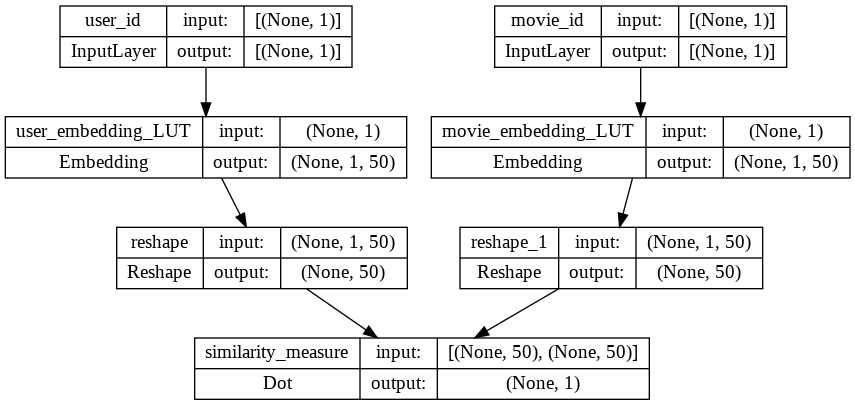

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,), name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1, name='similarity_measure')([user_emb, movie_emb])


# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90752, 2) (90752,)
(10084, 2) (10084,)


In [ ]:
# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 4s 3ms/step - loss: 9.2735 - root_mean_squared_error: 3.0449 - val_loss: 3.1535 - val_root_mean_squared_error: 1.7743
Epoch 2/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.9772 - root_mean_squared_error: 1.4033 - val_loss: 1.6351 - val_root_mean_squared_error: 1.2748
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.1592 - root_mean_squared_error: 1.0714 - val_loss: 1.3705 - val_root_mean_squared_error: 1.1654
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.9105 - root_mean_squared_error: 0.9471 - val_loss: 1.2778 - val_root_mean_squared_error: 1.1241
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7849 - root_mean_squared_error: 0.8775 - val_loss: 1.2453 - val_root_mean_squared_error: 1.1090


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        30500       ['input_8[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        486200      ['input_9[0][0]']                
                                                                                            

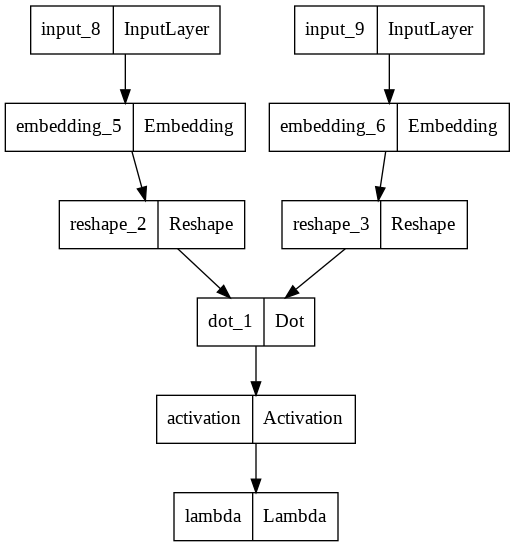

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()
plot_model(model)

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.3668 - root_mean_squared_error: 1.1688 - val_loss: 0.9254 - val_root_mean_squared_error: 0.9611
Epoch 2/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7733 - root_mean_squared_error: 0.8779 - val_loss: 0.8083 - val_root_mean_squared_error: 0.8971
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6077 - root_mean_squared_error: 0.7768 - val_loss: 0.7766 - val_root_mean_squared_error: 0.8784
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.4831 - root_mean_squared_error: 0.6909 - val_loss: 0.7681 - val_root_mean_squared_error: 0.8728
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.3860 - root_mean_squared_error: 0.6156 - val_loss: 0.7727 - val_root_mean_squared_error: 0.8747


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        30500       ['user_id[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        486200      ['movie_id[0][0]']               
                                                                                            

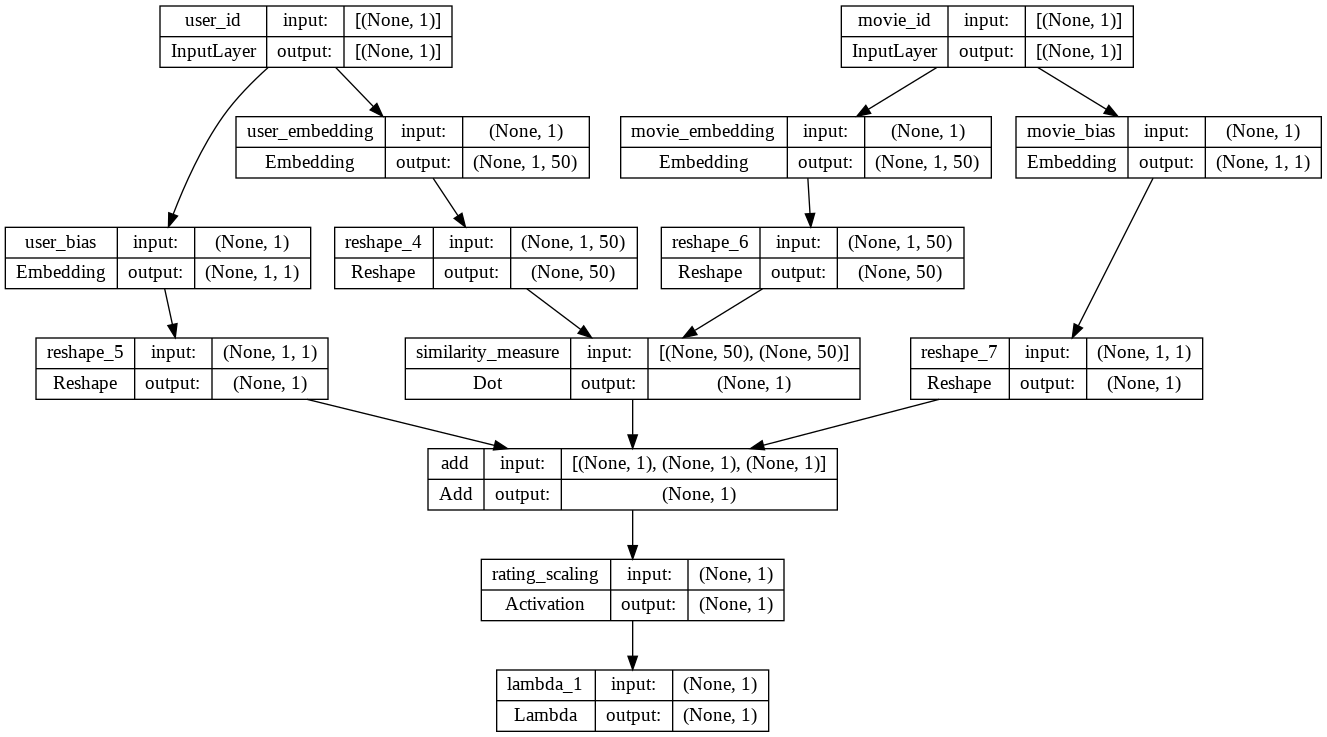

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1),name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='user_embedding')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6),name='user_bias')(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,),name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='movie_embedding')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6),name='movie_bias')(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Dot(axes=1,name='similarity_measure')([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Activation('sigmoid',name='rating_scaling')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True,to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 6s 3ms/step - loss: 1.1940 - root_mean_squared_error: 1.0924 - val_loss: 0.8511 - val_root_mean_squared_error: 0.9218
Epoch 2/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.7059 - root_mean_squared_error: 0.8389 - val_loss: 0.7558 - val_root_mean_squared_error: 0.8677
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.5501 - root_mean_squared_error: 0.7392 - val_loss: 0.7356 - val_root_mean_squared_error: 0.8552
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.4256 - root_mean_squared_error: 0.6485 - val_loss: 0.7386 - val_root_mean_squared_error: 0.8561
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.3297 - root_mean_squared_error: 0.5687 - val_loss: 0.7527 - val_root_mean_squared_error: 0.8635


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 50)        30500       ['input_10[0][0]']               
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 50)        486200      ['input_11[0][0]']               
                                                                                            

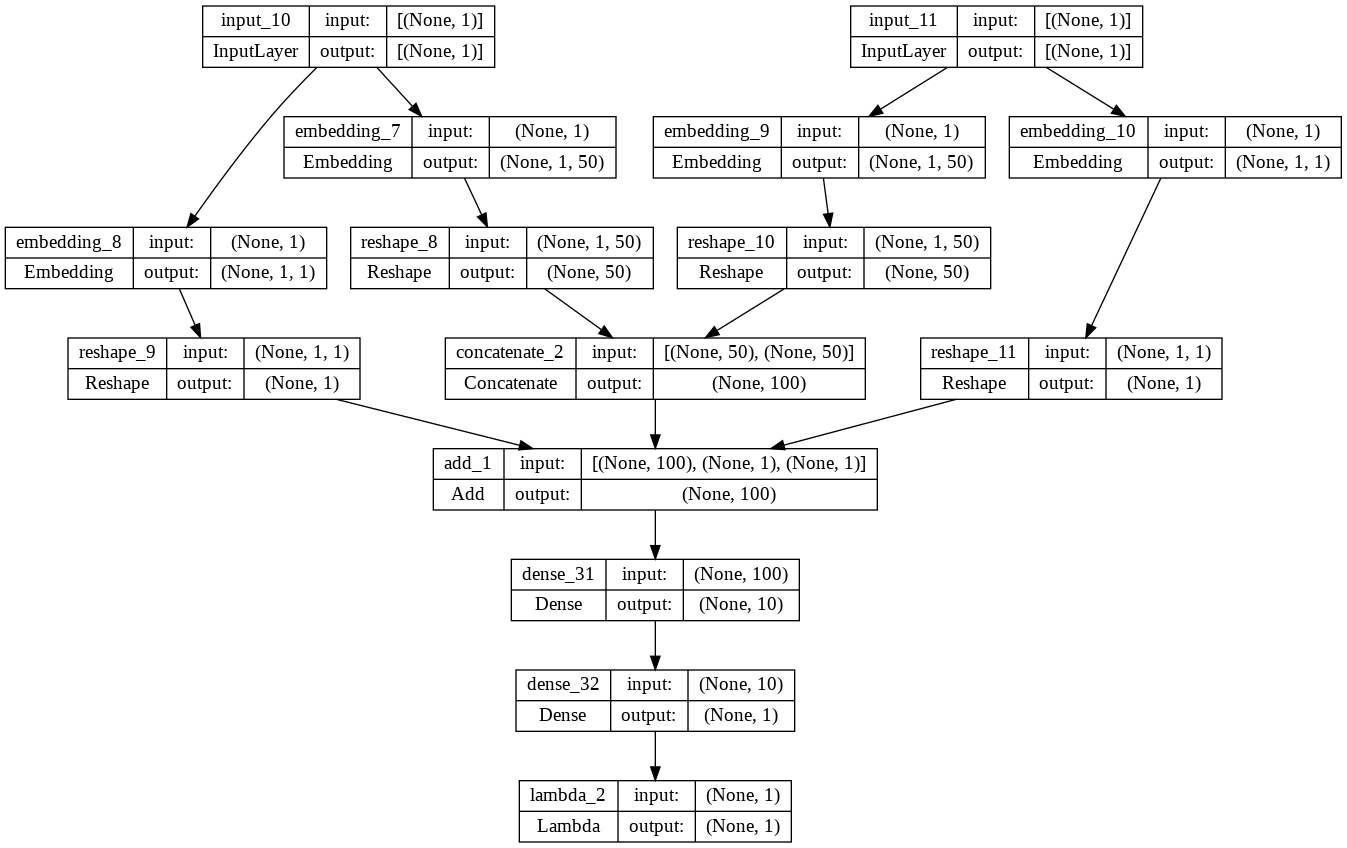

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz)(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1)(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz)(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1)(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True,to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 7s 4ms/step - loss: 0.8434 - root_mean_squared_error: 0.9183 - val_loss: 0.7843 - val_root_mean_squared_error: 0.8856
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6885 - root_mean_squared_error: 0.8298 - val_loss: 0.7708 - val_root_mean_squared_error: 0.8779
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6381 - root_mean_squared_error: 0.7988 - val_loss: 0.7681 - val_root_mean_squared_error: 0.8764
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6010 - root_mean_squared_error: 0.7752 - val_loss: 0.7749 - val_root_mean_squared_error: 0.8803
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.5680 - root_mean_squared_error: 0.7537 - val_loss: 0.7850 - val_root_mean_squared_error: 0.8860


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 50)        30500       ['input_12[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        486200      ['input_13[0][0]']               
                                                                                            

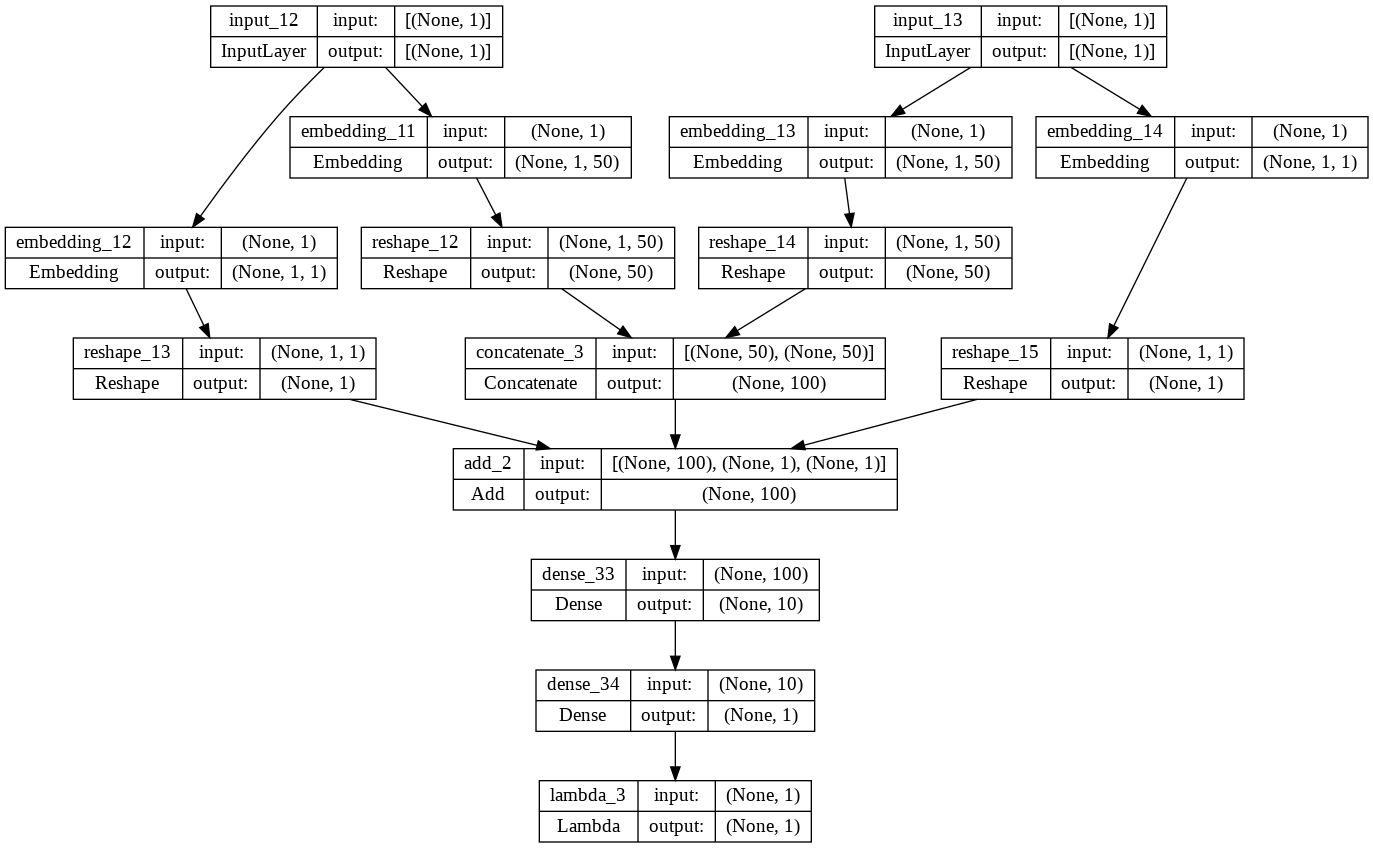

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True,to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.8285 - root_mean_squared_error: 0.9100 - val_loss: 0.7871 - val_root_mean_squared_error: 0.8869
Epoch 2/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6851 - root_mean_squared_error: 0.8273 - val_loss: 0.7722 - val_root_mean_squared_error: 0.8782
Epoch 3/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.6329 - root_mean_squared_error: 0.7947 - val_loss: 0.7771 - val_root_mean_squared_error: 0.8806
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.5946 - root_mean_squared_error: 0.7699 - val_loss: 0.7808 - val_root_mean_squared_error: 0.8825
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 0.5607 - root_mean_squared_error: 0.7473 - val_loss: 0.7961 - val_root_mean_squared_error: 0.8908


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 1, 50)        30500       ['input_14[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 50)        486200      ['input_15[0][0]']               
                                                                                            

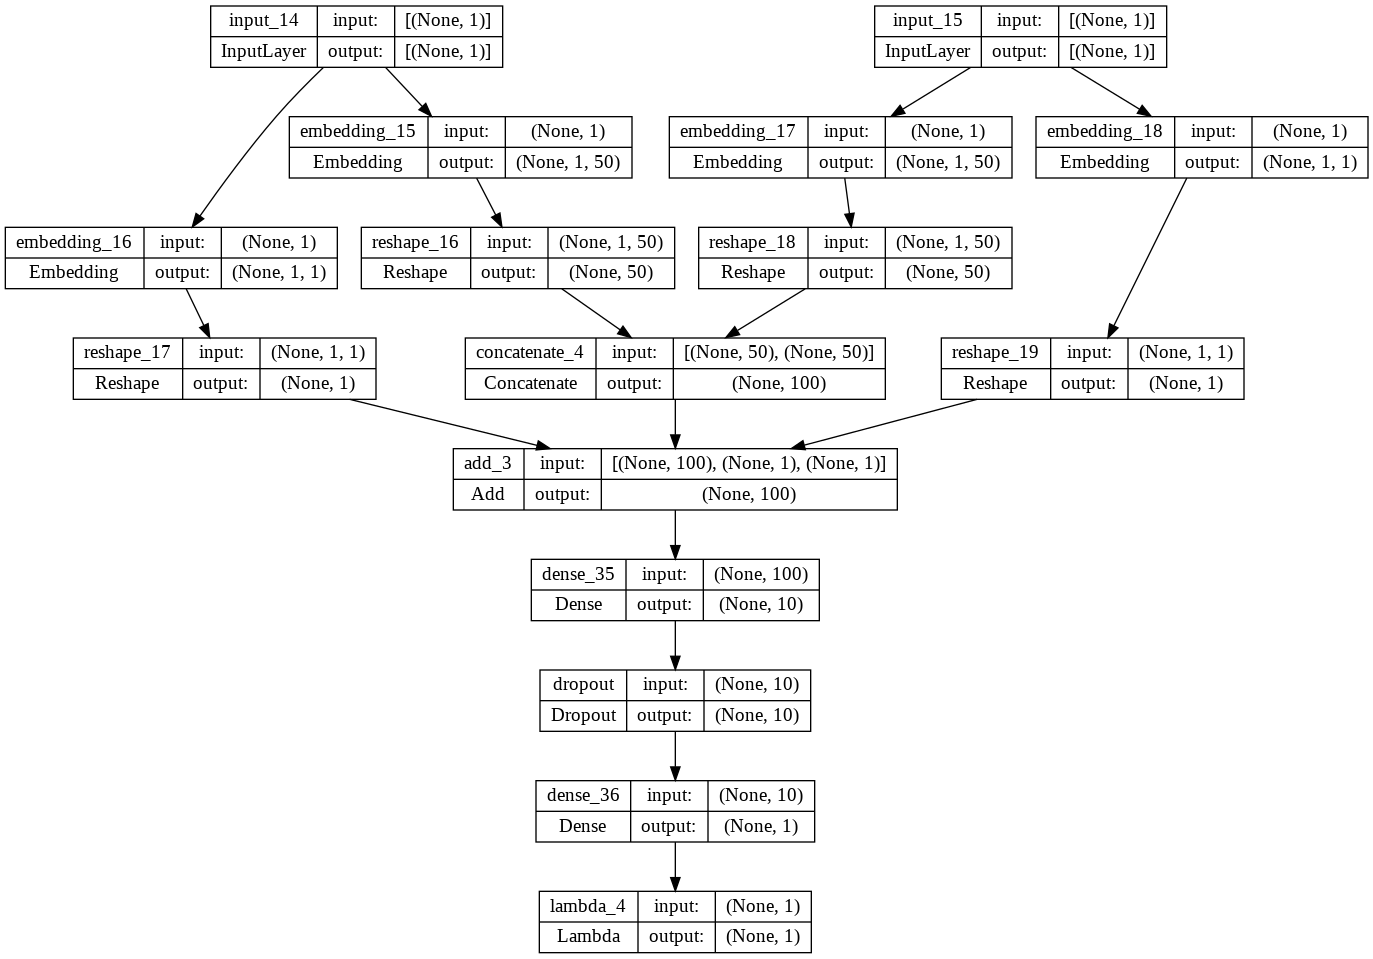

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True,to_file='model.png')

In [ ]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.9167 - root_mean_squared_error: 0.9573 - val_loss: 0.7932 - val_root_mean_squared_error: 0.8903
Epoch 2/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.7660 - root_mean_squared_error: 0.8748 - val_loss: 0.7765 - val_root_mean_squared_error: 0.8807
Epoch 3/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.7337 - root_mean_squared_error: 0.8559 - val_loss: 0.7803 - val_root_mean_squared_error: 0.8826
Epoch 4/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.7146 - root_mean_squared_error: 0.8444 - val_loss: 0.7747 - val_root_mean_squared_error: 0.8792
Epoch 5/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.7043 - root_mean_squared_error: 0.8381 - val_loss: 0.7816 - val_root_mean_squared_error: 0.8829
